In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold as kf

from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

random_seed=0


In [13]:
data = pd.read_csv("../Merging/Merged_Data.csv")

In [14]:

data['period'] = pd.to_datetime(data['period'])
data.sort_values(by='period', inplace=True)
plant_codes = data['plantCode'].unique()
data = data[data['period'] >= '2019-01-01']

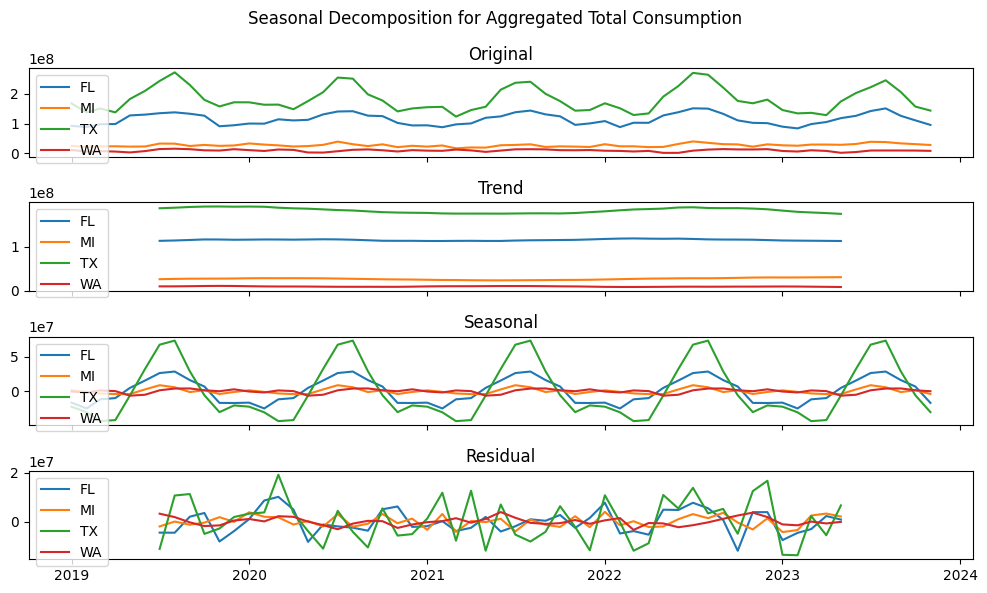

In [15]:
# Convert 'period' column to datetime
data['period'] = pd.to_datetime(data['period'])

# Group by 'period' and 'state', then sum 'total-consumption'
aggregated_data = data.groupby(['period', 'state'])['total-consumption'].sum().unstack().fillna(0)

# Perform seasonal decomposition on each state's total consumption
results = {}
for state, consumption in aggregated_data.items():
    result = seasonal_decompose(consumption, model='additive', period=12)
    results[state] = result

# Plot the decomposed components for aggregated total consumption of each state
fig, axs = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

for state, result in results.items():
    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid

    axs[0].plot(aggregated_data.index, aggregated_data[state], label=state)
    axs[1].plot(trend, label=state)
    axs[2].plot(seasonal, label=state)
    axs[3].plot(residual, label=state)

axs[0].set_title("Original")
axs[1].set_title("Trend")
axs[2].set_title("Seasonal")
axs[3].set_title("Residual")

for ax in axs:
    ax.legend(loc='upper left')

plt.suptitle("Seasonal Decomposition for Aggregated Total Consumption")
plt.tight_layout()
plt.show()

# plot on separate axes

In [16]:
# Define the time periods and features for training and testing
start_train = '2019-01-01'
end_train = '2022-12-31'
start_test = '2023-01-01'
end_test = '2023-12-31'
model_features = ['ELEVATION', 'TEMP',
       'WDSP', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'SNDP','TEMPEXT_BASE40', 'TEMPEXT_BASE45', 'TEMPEXT_BASE50', 
       'OVER_60', 'OVER_70', 'OVER_80', 'UNDER_40', 'UNDER_30', 'UNDER_20',
       'SUM_OVER_UNDER', 'LATITUDE','LONGITUDE','Zip','plantCode']

In [38]:
def train_test_and_plot(data, model, start_train, end_train, start_test, end_test, model_features, n_examples=3):
    # Exclude negative consumption values
    data = data[data['total-consumption'] >= 0]

    # Convert 'state' column to categorical type
    data['state'] = data['state'].astype('category')
    
    # Extract features and target variable
    X = data[model_features].fillna(0)
    y = data['total-consumption']

    # Filter the data for training and testing
    train_data = data[(data['period'] >= start_train) & (data['period'] <= end_train)]
    test_data = data[(data['period'] >= start_test) & (data['period'] <= end_test)]

    # Extract features and target variable for training
    X_train = train_data[model_features]
    y_train = train_data['total-consumption']

    # Extract features and target variable for testing
    X_test = test_data[model_features]
    y_test = test_data['total-consumption']

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print('Model evaluation:')
    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')

    # Plotting the predicted vs. actual total consumption
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_pred, c=test_data['state'].cat.codes, cmap='viridis', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)  # Plotting the diagonal line
    plt.title('Predicted vs. Actual Total Consumption')
    plt.xlabel('Actual Total Consumption')
    plt.ylabel('Predicted Total Consumption')

    plt.grid(True)

    plt.show()


    # Plotting predicted and actual values against timescale 'period'
    plt.figure(figsize=(12, 6))
    plt.scatter(test_data['period'], y_test, label='Actual', alpha=0.5)
    plt.scatter(test_data['period'], y_pred, label='Predicted', alpha=0.5)
    plt.title('Actual vs. Predicted Total Consumption Over Time')
    plt.xlabel('Period')
    plt.ylabel('Total Consumption')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate absolute difference between predicted and actual values
    test_data['abs_diff'] = np.abs(y_pred - y_test)

    # Sort data by absolute difference in descending order
    sorted_data = test_data.sort_values(by='abs_diff', ascending=False)

    # Get plant codes with worst predicted vs. actual values
    worst_plant_codes = sorted_data['plantCode'].unique()[:n_examples]

    # Plot worst examples
    for plant_code in worst_plant_codes:
        plant_data = test_data[test_data['plantCode'] == plant_code].reset_index(drop=True)  # Reset index
        plt.figure(figsize=(12, 6))
        plt.scatter(plant_data['total-consumption'], y_pred[plant_data.index], c=plant_data['state'].cat.codes, cmap='viridis', alpha=0.5)
        plt.plot([min(plant_data['total-consumption']), max(plant_data['total-consumption'])], [min(plant_data['total-consumption']), max(plant_data['total-consumption'])], 'k--', lw=2)  # Plotting the diagonal line
        plt.title(f'Predicted vs. Actual Total Consumption for Plant Code {plant_code}')
        plt.xlabel('Actual Total Consumption')
        plt.ylabel('Predicted Total Consumption')
        plt.grid(True)
        plt.show()


    # Perform PCA on the entire dataset
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=20)  # Specify the number of components to retain
    pca.fit(X_scaled)

    # Visualize explained variance ratio
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center')
    plt.step(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), where='mid')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio by Principal Components')
    plt.show()

    # Feature Importance
    if hasattr(model, 'feature_importances_'):
        feature_importance = model.feature_importances_
        sorted_idx = np.argsort(feature_importance)
        print(feature_importance)
        top_features = np.array(model_features)[sorted_idx][-10:]  # Adjust the number of top features as needed
        pos = np.arange(top_features.shape[0]) + .5
        plt.figure(figsize=(10, 6))
        plt.barh(pos, feature_importance[sorted_idx][-10:], align='center')
        plt.yticks(pos, top_features)
        plt.xlabel('Feature Importance')
        plt.title('Top 10 Feature Importance')
        plt.show()


    # Perform PCA on the entire dataset
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=20)  # Specify the number of components to retain
    pca.fit(X_scaled)

    # Visualize explained variance ratio
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center')
    plt.step(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), where='mid')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio by Principal Components')
    plt.show()

    # Feature Importance
    if hasattr(model, 'feature_importances_'):
        feature_importance = model.feature_importances_
        sorted_idx = np.argsort(feature_importance)
        print(feature_importance)
        top_features = np.array(model_features)[sorted_idx][-10:]  # Adjust the number of top features as needed
        pos = np.arange(top_features.shape[0]) + .5
        plt.figure(figsize=(10, 6))
        plt.barh(pos, feature_importance[sorted_idx][-10:], align='center')
        plt.yticks(pos, top_features)
        plt.xlabel('Feature Importance')
        plt.title('Top 10 Feature Importance')
        plt.show()


Model evaluation:
Mean Squared Error: 486055491352.10425
R-squared: 0.8738411479645536


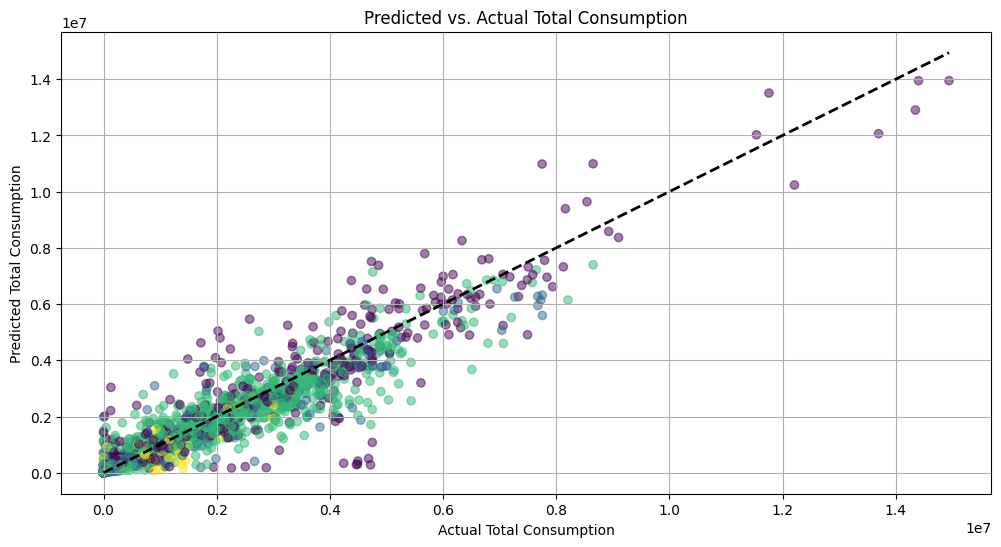

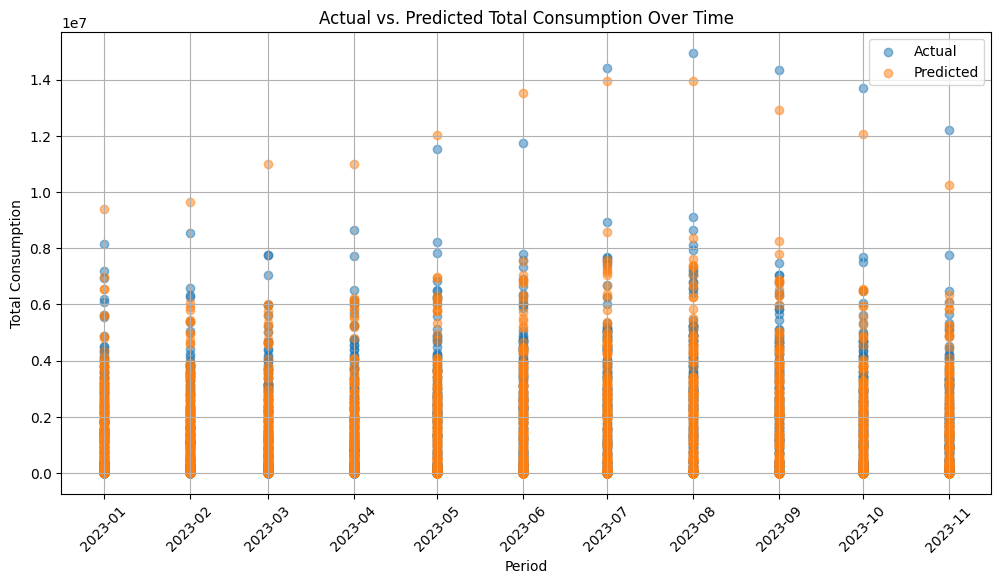

C:\Users\nicoesse\AppData\Local\Temp\ipykernel_16832\2074057828.py:64: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



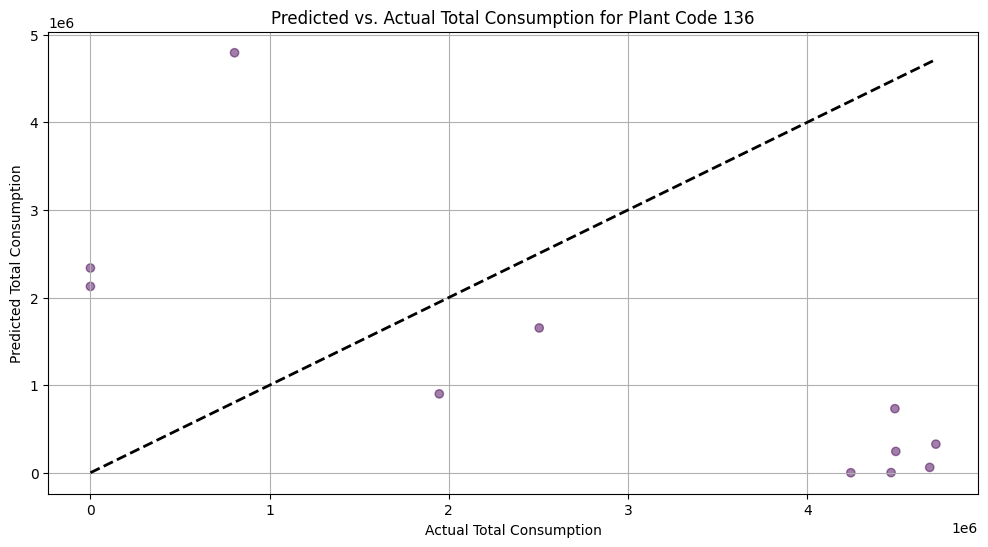

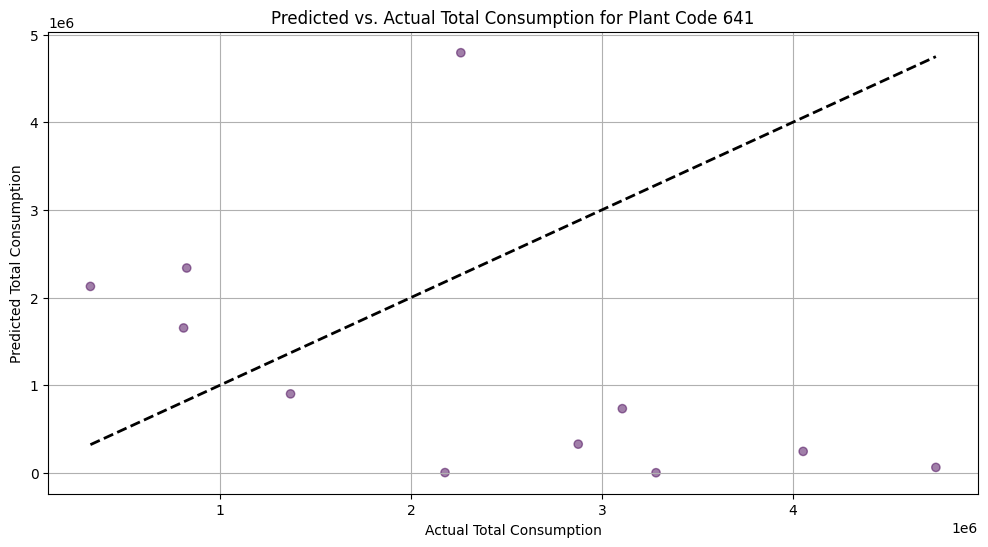

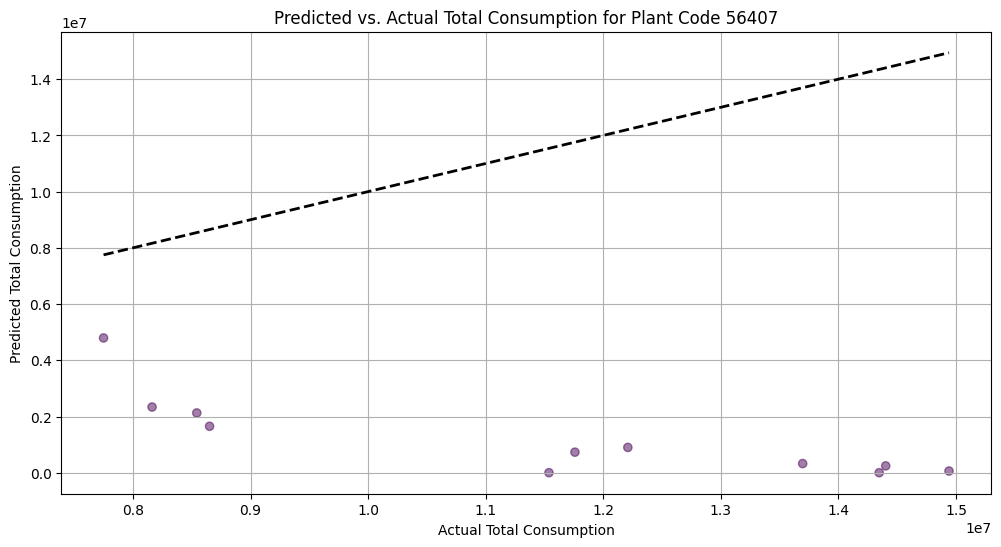

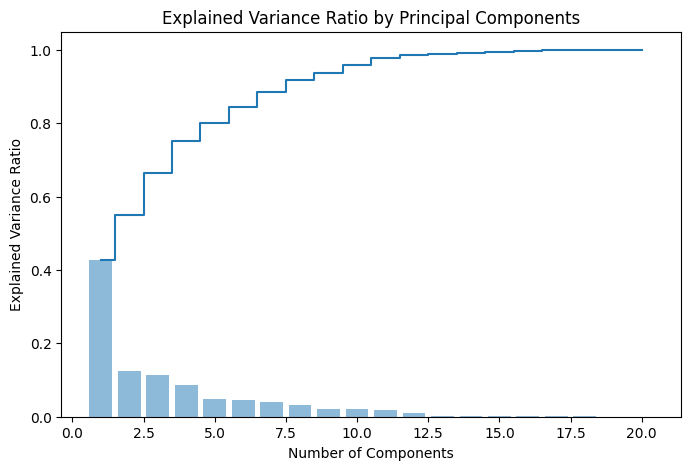

[6.26953882e-02 2.67689277e-03 1.25702295e-02 7.42496512e-03
 1.07242466e-02 2.04501170e-02 1.39784988e-02 1.32365586e-02
 2.31487735e-05 3.08169806e-03 3.47316246e-03 3.23362307e-03
 2.37982685e-03 4.25109255e-03 3.02829450e-03 9.42195714e-04
 2.09232761e-04 4.31944368e-05 4.29928476e-03 1.12089822e-01
 8.14283781e-02 1.57668041e-01 4.80092109e-01]


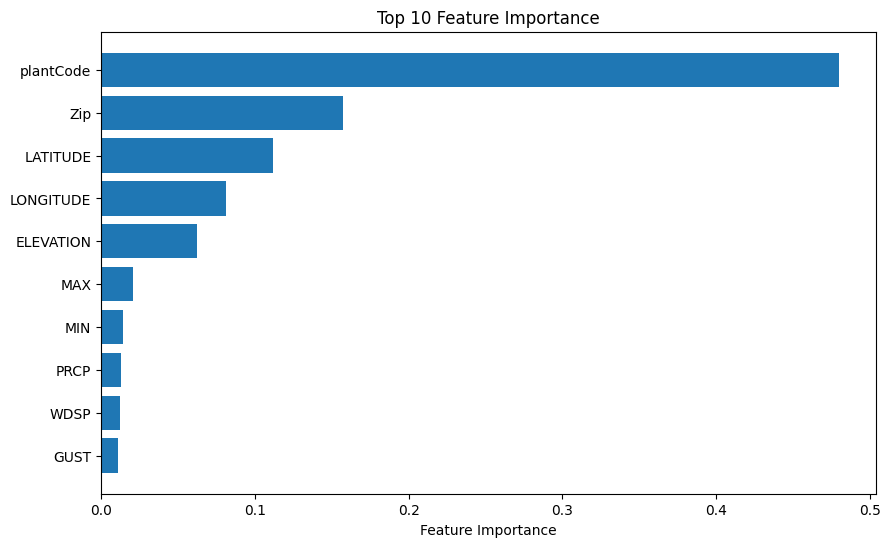

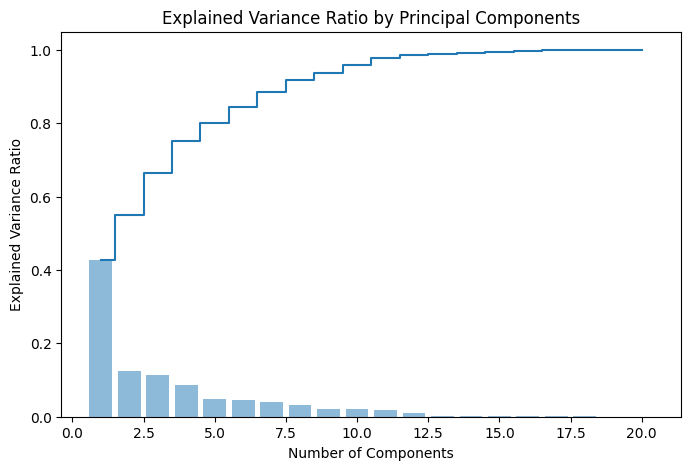

[6.26953882e-02 2.67689277e-03 1.25702295e-02 7.42496512e-03
 1.07242466e-02 2.04501170e-02 1.39784988e-02 1.32365586e-02
 2.31487735e-05 3.08169806e-03 3.47316246e-03 3.23362307e-03
 2.37982685e-03 4.25109255e-03 3.02829450e-03 9.42195714e-04
 2.09232761e-04 4.31944368e-05 4.29928476e-03 1.12089822e-01
 8.14283781e-02 1.57668041e-01 4.80092109e-01]


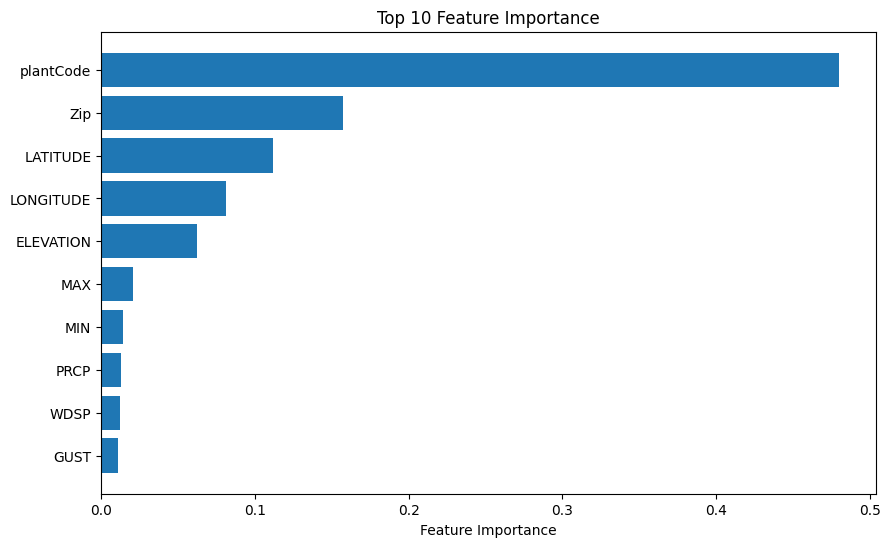

In [39]:
rf_model = RandomForestRegressor(n_estimators = 150,
                                 max_depth = 20,
                                 min_samples_split = 10,
                                 random_state = random_seed)


# Call the function with the model and other parameters
train_test_and_plot(data, rf_model, start_train, end_train, start_test, end_test, model_features)

Model evaluation:
Mean Squared Error: 488978950869.9931
R-squared: 0.873082345104981


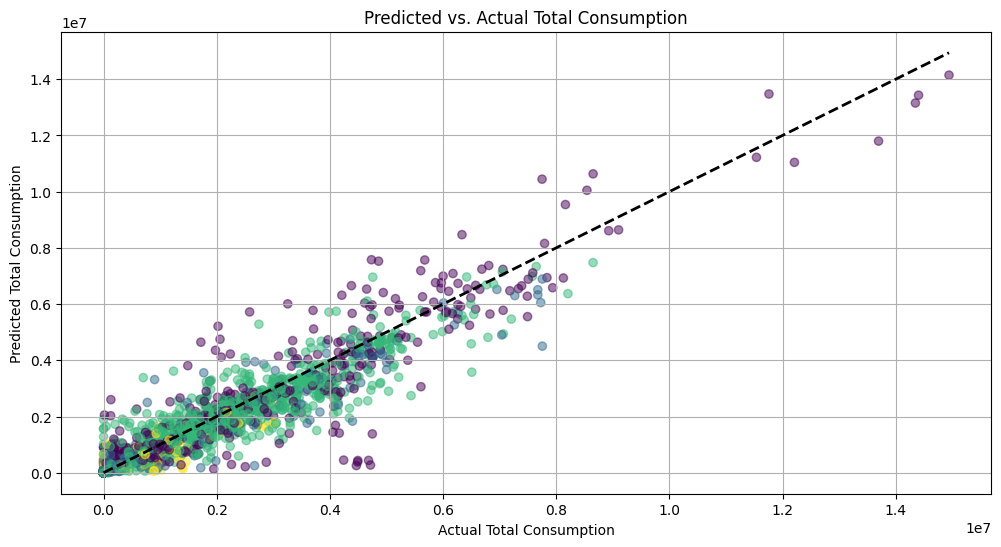

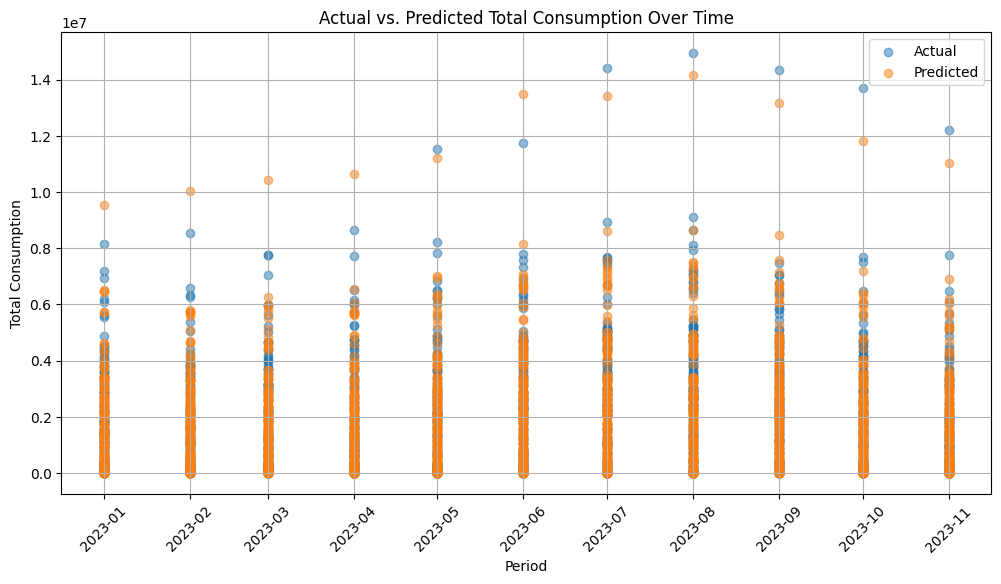

C:\Users\nicoesse\AppData\Local\Temp\ipykernel_16832\2074057828.py:64: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



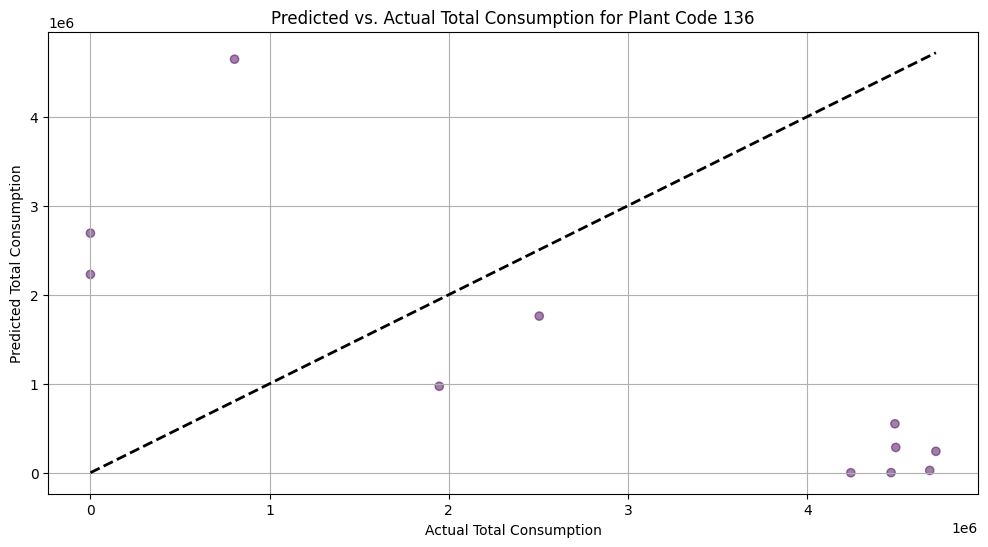

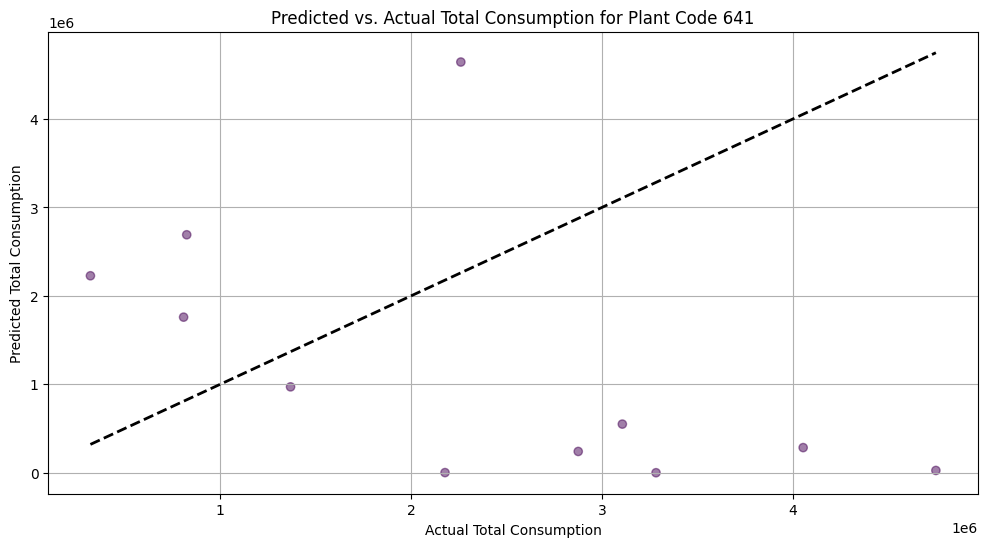

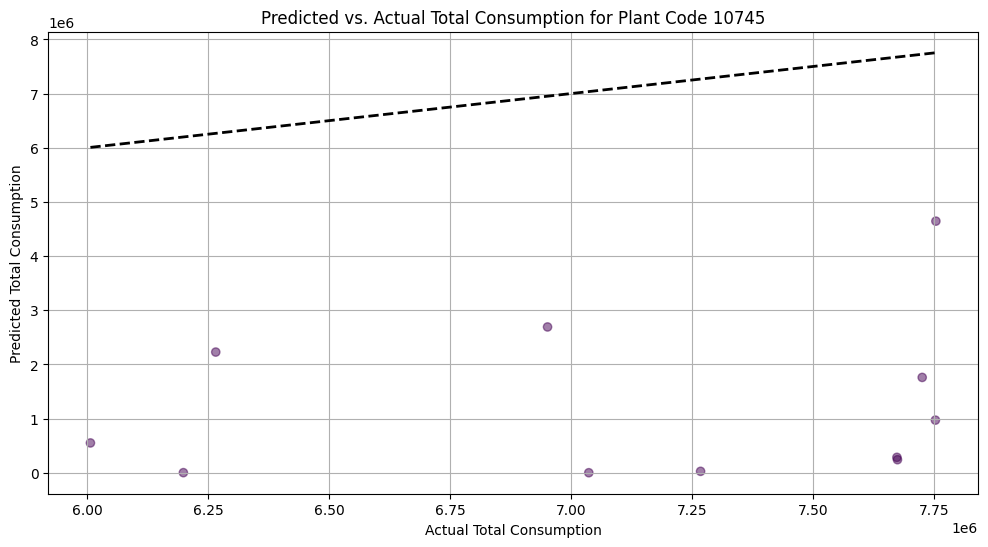

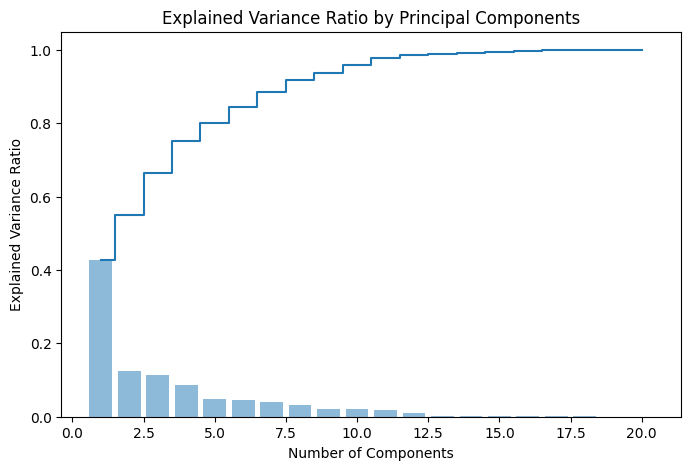

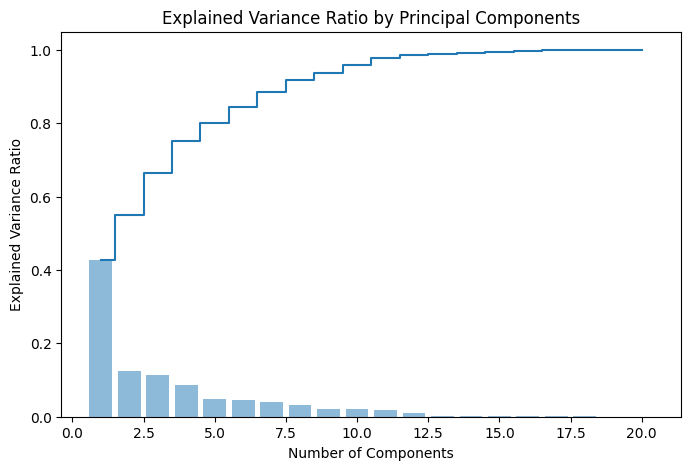

In [40]:
knn_model = KNeighborsRegressor(n_neighbors = 7,
                                weights = 'distance',
                                algorithm = 'ball_tree')

# Call the train_test_and_plot function
train_test_and_plot(data, knn_model, start_train, end_train, start_test, end_test, model_features)


Model evaluation:
Mean Squared Error: 981605650946.8458
R-squared: 0.7452178932687927


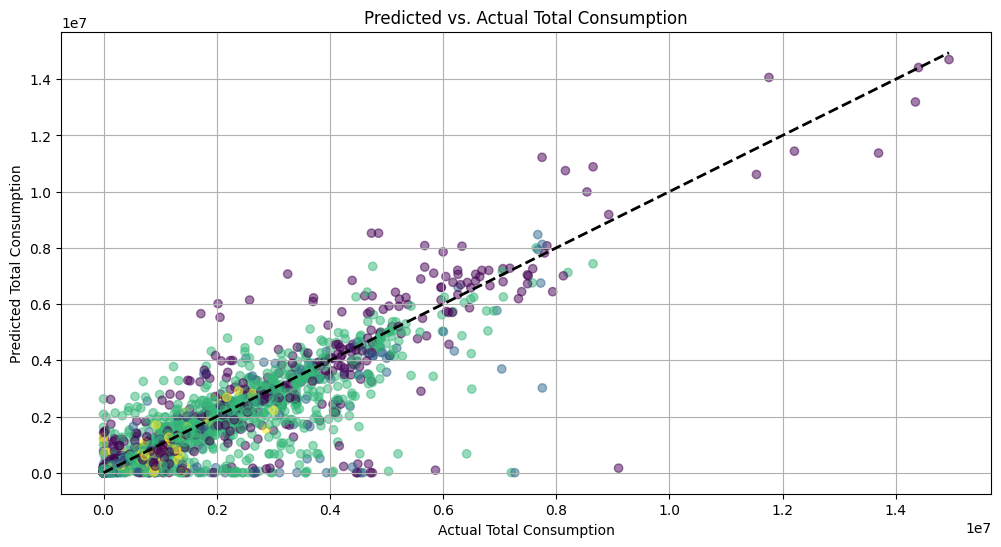

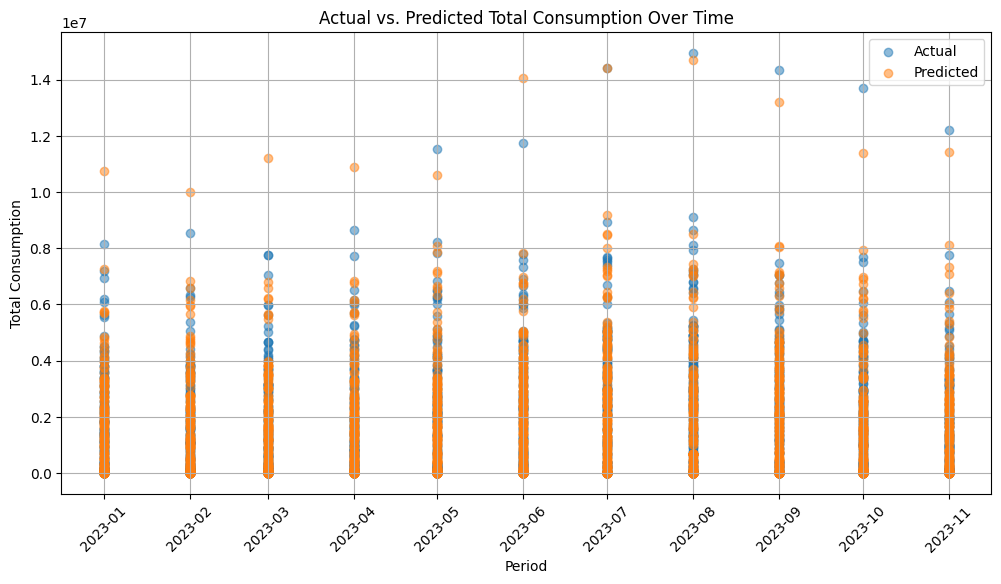

C:\Users\nicoesse\AppData\Local\Temp\ipykernel_16832\2074057828.py:64: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



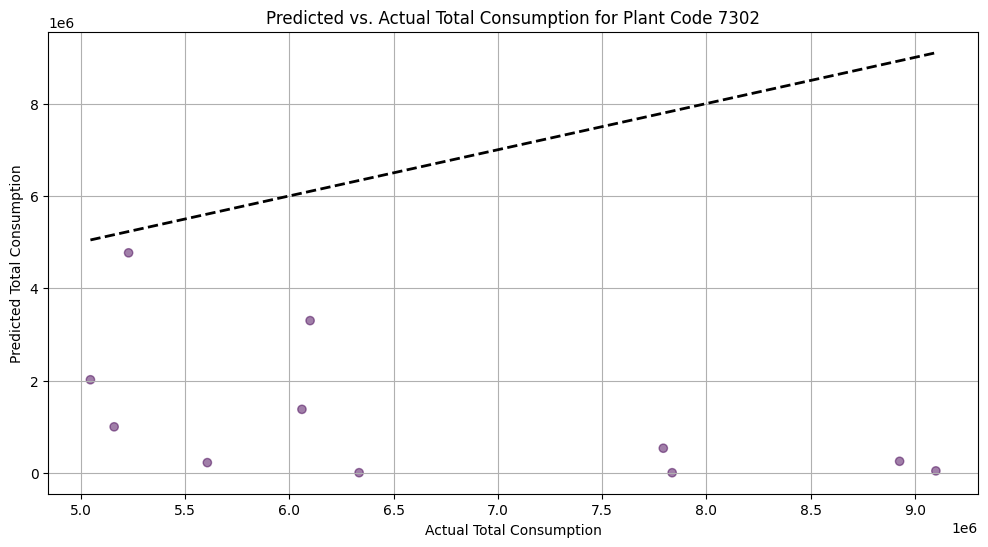

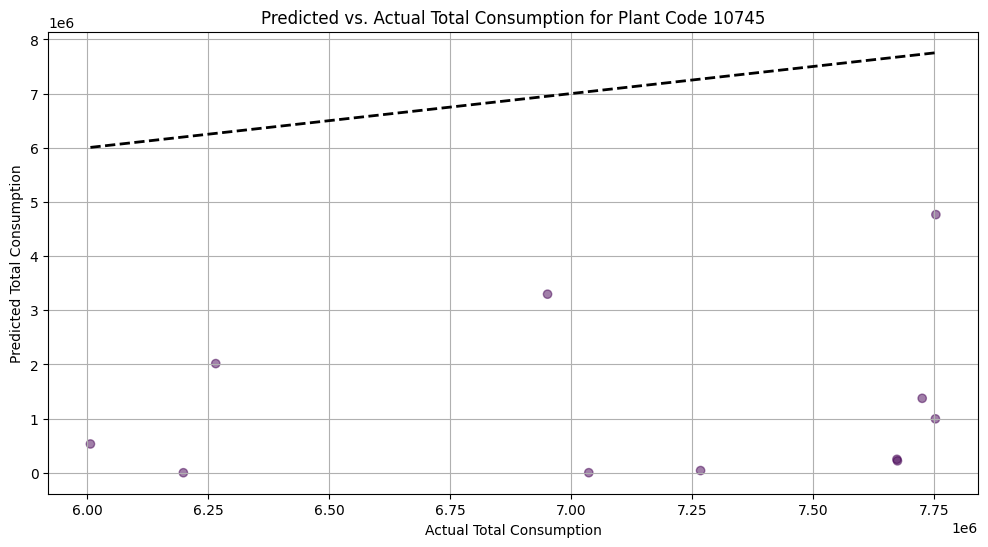

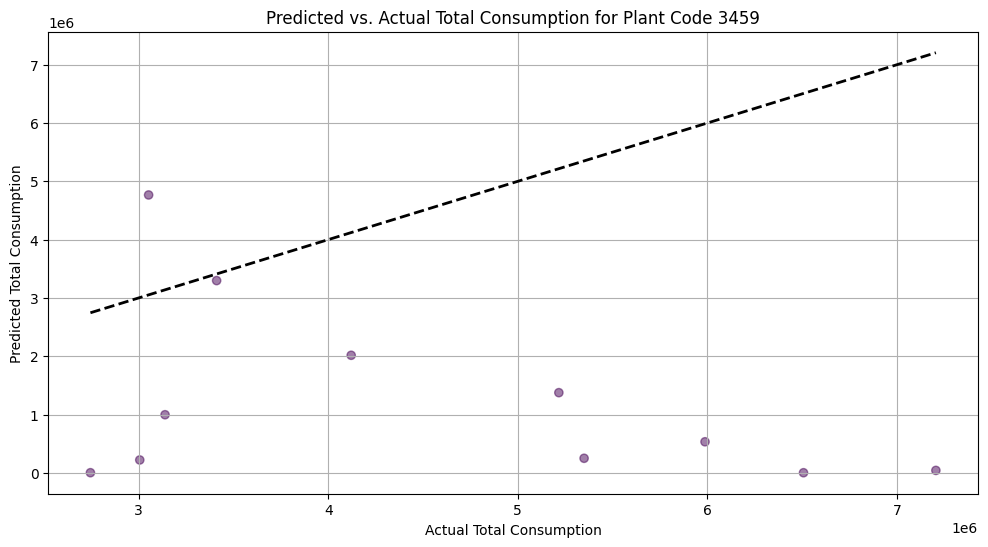

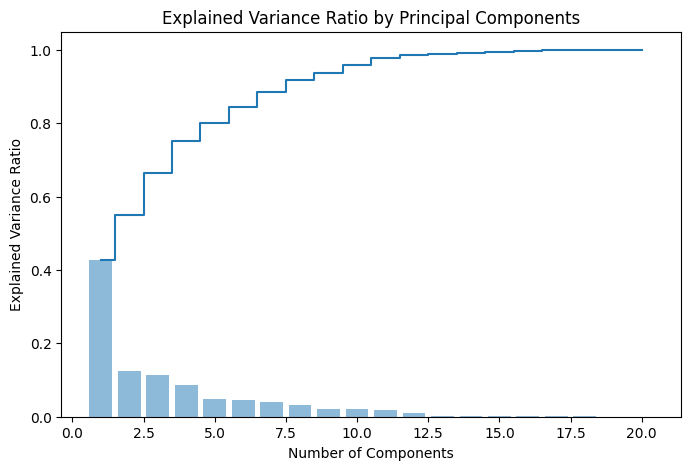

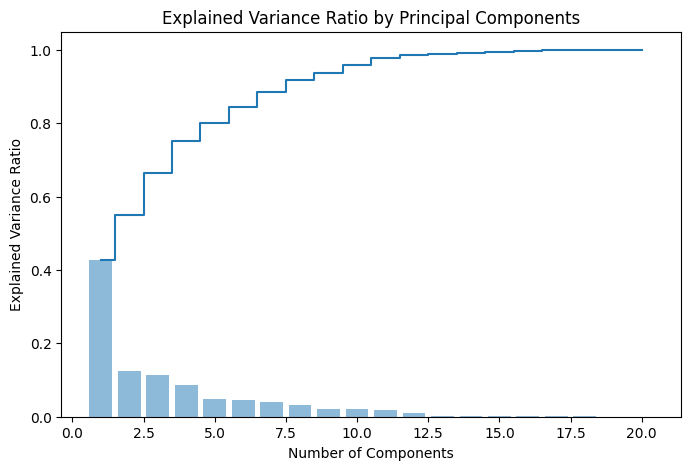

In [41]:
nb_model = GaussianNB()
train_test_and_plot(data, nb_model, start_train, end_train, start_test, end_test, model_features)


In [72]:
# Sensitivity Analysis on RandomForest


# Define ranges for hyperparameters
n_estimators_range = [50, 100, 150]
max_depth_range = [10, 15, 20, 25]
min_samples_split_range = [2, 5, 8, 10]

# Initialize lists to store results
mse_results = []
std_results = []

# Exclude negative consumption values
data = data[data['total-consumption'] > 0]

# Convert 'state' column to categorical type
data['state'] = data['state'].astype('category')
    
# Extract features and target variable
X = data[model_features].fillna(0)
y = data['total-consumption']
# Filter the data for training and testing
train_data = data[(data['period'] >= start_train) & (data['period'] <= end_train)]
test_data = data[(data['period'] >= start_test) & (data['period'] <= end_test)]

# Extract features and target variable for training
X_train = train_data[model_features]
y_train = train_data['total-consumption']

# Extract features and target variable for testing
X_test = test_data[model_features]
y_test = test_data['total-consumption']

# Perform sensitivity analysis
for n_estimators in n_estimators_range:
    for max_depth in max_depth_range:
        for min_samples_split in min_samples_split_range:
            # Create Random Forest model with current hyperparameters
            rf_model = RandomForestRegressor(n_estimators=n_estimators,
                                              max_depth=max_depth,
                                              min_samples_split=min_samples_split,
                                              random_state = random_seed))
            # Perform k-fold cross-validation
            mse_scores = []
            kfolder = kf(n_splits=5, random_state=None, shuffle=False)
            for train_index, test_index in kf.split(kfolder, X_train):
                X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
                y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
                
                # Train model on current fold
                rf_model.fit(X_train_fold, y_train_fold)
                
                # Predict on test fold and calculate MSE
                y_pred_fold = rf_model.predict(X_test_fold)
                mse_fold = mean_squared_error(y_test_fold, y_pred_fold)
                mse_scores.append(mse_fold)
            
            # Calculate mean MSE and standard deviation
            mean_mse = np.mean(mse_scores)
            std_mse = np.std(mse_scores)
            
            # Store results
            mse_results.append(mean_mse)
            std_results.append(std_mse)



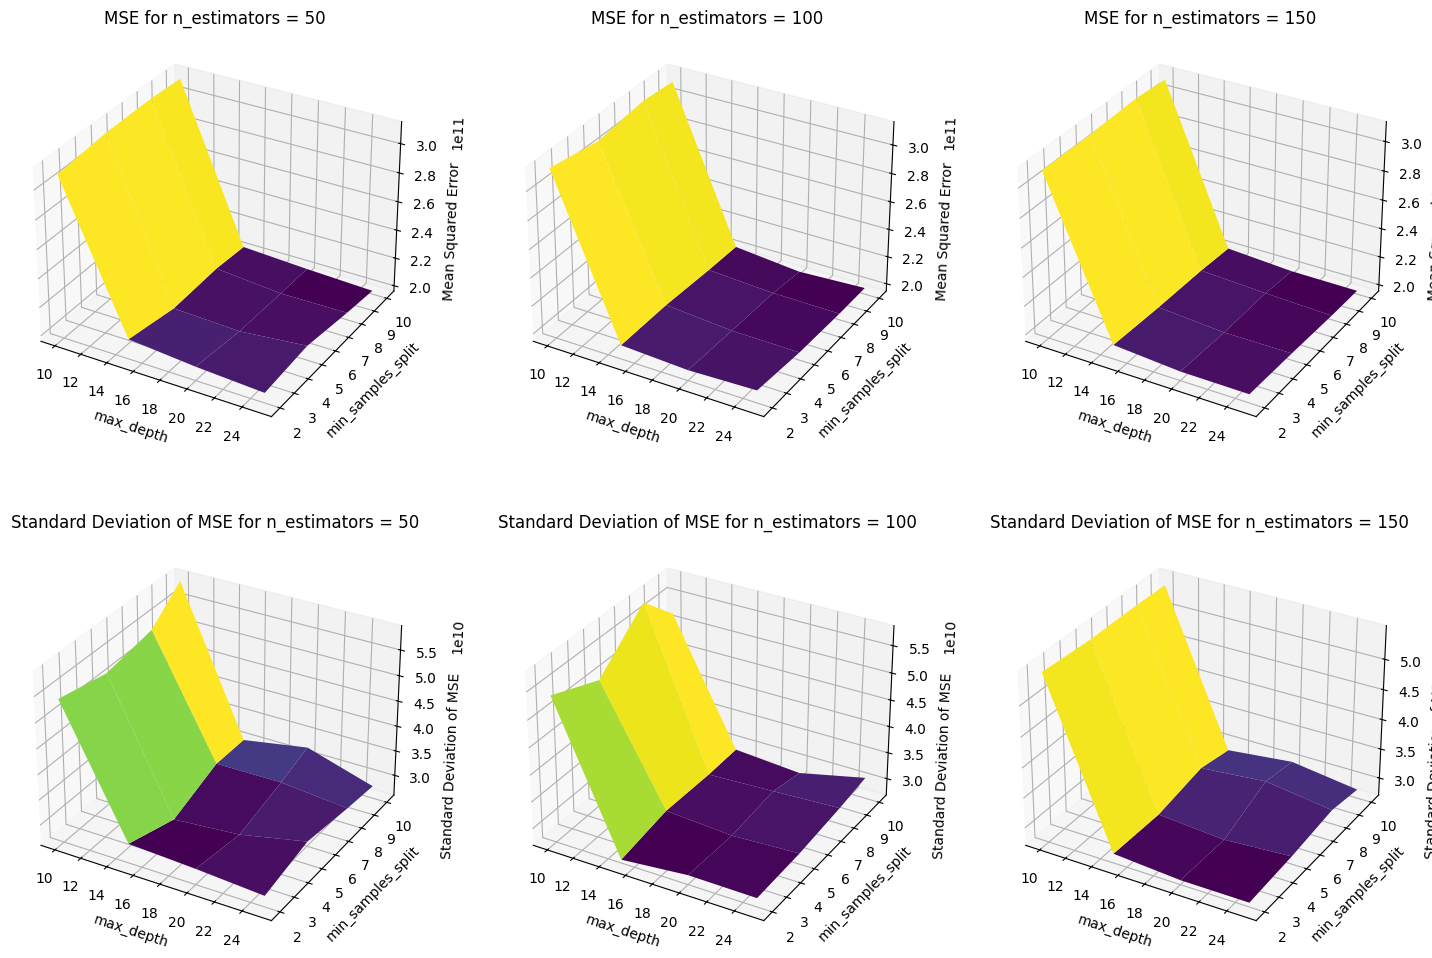

In [93]:
# Reshape mse_results and std_results into 3D arrays
mse_results_3d = np.array(mse_results).reshape(len(n_estimators_range), len(max_depth_range), len(min_samples_split_range))
std_results_3d = np.array(std_results).reshape(len(n_estimators_range), len(max_depth_range), len(min_samples_split_range))

# Create meshgrid for 3D plotting
MAX_DEPTH_VALUES, MIN_SAMPLES_SPLIT = np.meshgrid(max_depth_range, min_samples_split_range)

# Create a figure with multiple subplots
fig = plt.figure(figsize=(18, 12))


# Plot MSE surface plots
for i in range(3):
    mse_slice = mse_results_3d[i].T
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    surf = ax.plot_surface(MAX_DEPTH_VALUES, MIN_SAMPLES_SPLIT, mse_slice, cmap='viridis')
    ax.set_xlabel('max_depth')
    ax.set_ylabel('min_samples_split')
    ax.set_zlabel('Mean Squared Error              ')
    ax.set_title(f'MSE for n_estimators = {n_estimators_range[i]}')

# Plot Standard Deviation surface plots
for i in range(3):
    std_slice = std_results_3d[i].T
    ax = fig.add_subplot(2, 3, i+4, projection='3d')
    surf = ax.plot_surface(MAX_DEPTH_VALUES, MIN_SAMPLES_SPLIT, std_slice, cmap='viridis')
    ax.set_xlabel('max_depth')
    ax.set_ylabel('min_samples_split')
    ax.set_zlabel('Standard Deviation of MSE                            ')
    ax.set_title(f'Standard Deviation of MSE for n_estimators = {n_estimators_range[i]}')

plt.show()
